# Hydrostatic equilibrum

In [1]:
from ppmpy.euler import Euler
from ppmpy.gravity import constant_gravity
import numpy as np

In [2]:
def hse(grid, v, gamma, U, params):
    rho_base = params["base_density"]
    pres_base = params["base_pressure"]
    g = params["g_const"]

    # we will assume we are isothermal and constant composition.  In that case,
    # p/rho = constant
    A = pres_base / rho_base
    
    # we will discretize HSE as second-order
    # p_{i+1} = p_i + dx / 2 (rho_i + rho_{i+1} g
    # but we can write p_{i+1} = A rho_{i+1} and solve for rho_{i+1}
    
    p = grid.scratch_array()
    rho = grid.scratch_array()

    # we want the base conditions to be at the lower boundary.  We will
    # set the conditions in the first zone center from the analytic expression:
    # P = P_base e^{-z/H}
    
    H = pres_base / rho_base / np.abs(g)
    
    p[grid.lo] = pres_base * np.exp(-grid.x[grid.lo] / H)
    rho[grid.lo] = rho_base * np.exp(-grid.x[grid.lo] / H)

    for i in range(grid.lo+1, grid.hi+1):
        rho[i] = (p[i-1] + 0.5 * grid.dx * rho[i-1] * g) / (A - 0.5 * grid.dx * g)
        p[i] = A * rho[i]

    # now check:
    max_err = 0.0
    for i in range(grid.lo+1, grid.hi+1):
        dpdr = (p[i] - p[i-1])/grid.dx
        rhog = 0.5 * (rho[i] + rho[i-1]) * g
        err = np.abs(dpdr - rhog) / np.abs(rhog)
        max_err = max(max_err, err)

    print(f"max err = {max_err}")
    
    # now fill the conserved variables
    U[:, v.urho] = rho[:]
    U[:, v.umx] = 0.0
    U[:, v.uener] = p[:] / (gamma - 1.0)

In [3]:
params = {"base_density": 1.0, "base_pressure": 1.0, "g_const": -1.0}
e = Euler(32, 0.5, init_cond=hse, grav_func=constant_gravity,
          bc_left_type="reflect", bc_right_type="reflect",
          params=params)

max err = 4.758772240726933e-15


In [4]:
import numpy as np
import matplotlib.pyplot as plt

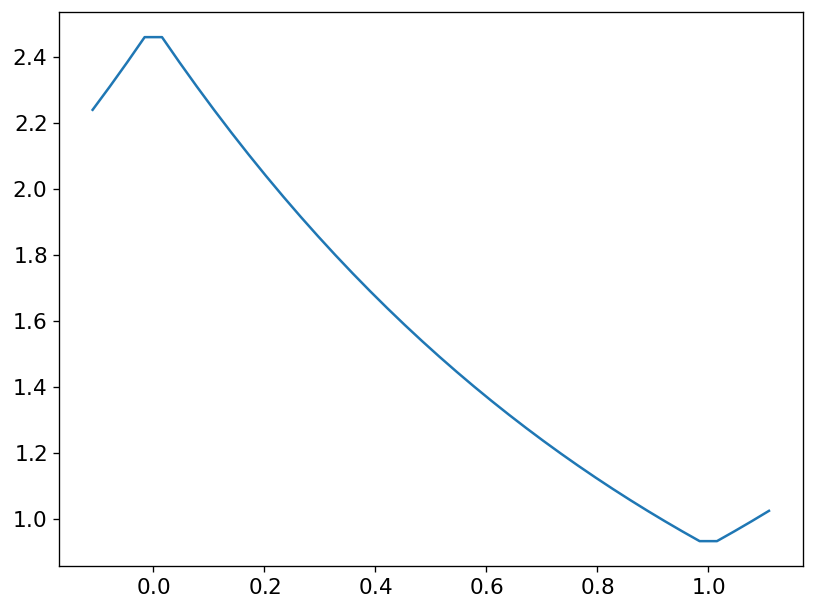

In [5]:
fig, ax = plt.subplots()
ax.plot(e.grid.x, e.U[:, 2])

## Convergence testing

In [6]:
simulations = []
for nx in [32, 64, 128, 256]:
    dt = 0.0128 * (32 / nx)
    e = Euler(nx, 0.5, fixed_dt=dt, init_cond=hse,
              use_limiting=False, use_flattening=False,
              bc_left_type="reflect", bc_right_type="reflect", params=params)
    e.evolve(0.64, verbose=False)
    print(e.nstep)
    simulations.append(e)

max err = 4.758772240726933e-15
50
max err = 1.013201599565906e-14
101
max err = 2.368723905155367e-14
201
max err = 4.7024529928098215e-14
400


In [7]:
from itertools import pairwise
ivar = 0

In [8]:
for coarse, fine in pairwise(simulations):
    _, cd = fine.grid.coarsen(fine.U[:, ivar])
    err = coarse.grid.norm(coarse.U[:, ivar] - cd)
    print(f"{fine.grid.nx:3d} -> {coarse.grid.nx:3d} : {err}")

 64 ->  32 : 0.0005876841946047128
128 ->  64 : 0.00026930754172175577
256 -> 128 : 0.00011918938266738842


In [9]:
for s in simulations:
    init = s.grid.scratch_array(nc=3)
    hse(s.grid, s.v, s.gamma, init, params)
    print(f"{s.grid.nx:3d} : {s.grid.norm(init[:, ivar] - s.U[:, ivar]) }")

max err = 4.758772240726933e-15
 32 : 0.21827721062227698
max err = 1.013201599565906e-14
 64 : 0.21836027053082152
max err = 2.368723905155367e-14
128 : 0.21838105691521614
max err = 4.7024529928098215e-14
256 : 0.2183862494090449


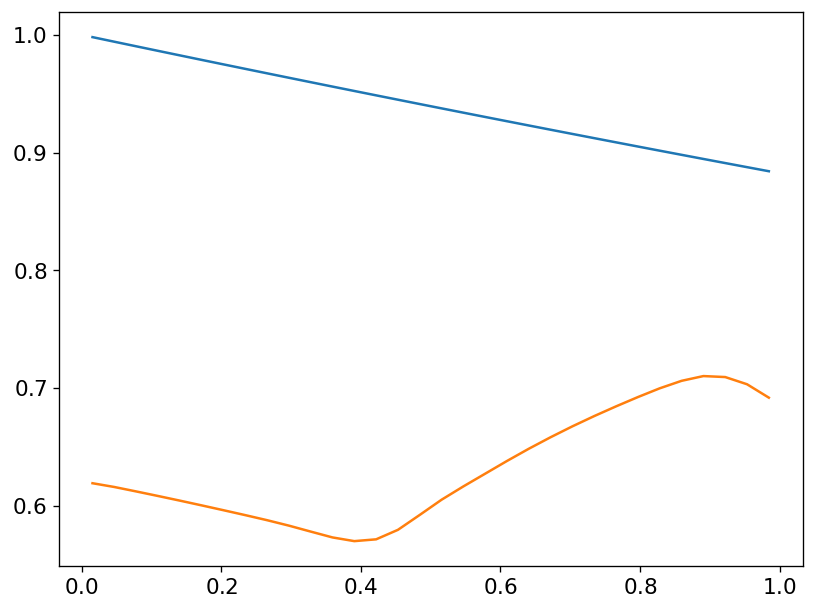

In [10]:
s = simulations[0]
fig, ax = plt.subplots()
ax.plot(s.grid.x[s.grid.lo:s.grid.hi+1], init[s.grid.lo:s.grid.hi+1, ivar])
ax.plot(s.grid.x[s.grid.lo:s.grid.hi+1], s.U[s.grid.lo:s.grid.hi+1, ivar])

In [11]:
nx = 32
dt = 0.0128 * (32 / nx)
e = Euler(nx, 0.5, fixed_dt=dt, init_cond=hse,
          use_limiting=False, use_flattening=False,
          bc_left_type="reflect", bc_right_type="reflect", params=params)

max err = 4.758772240726933e-15


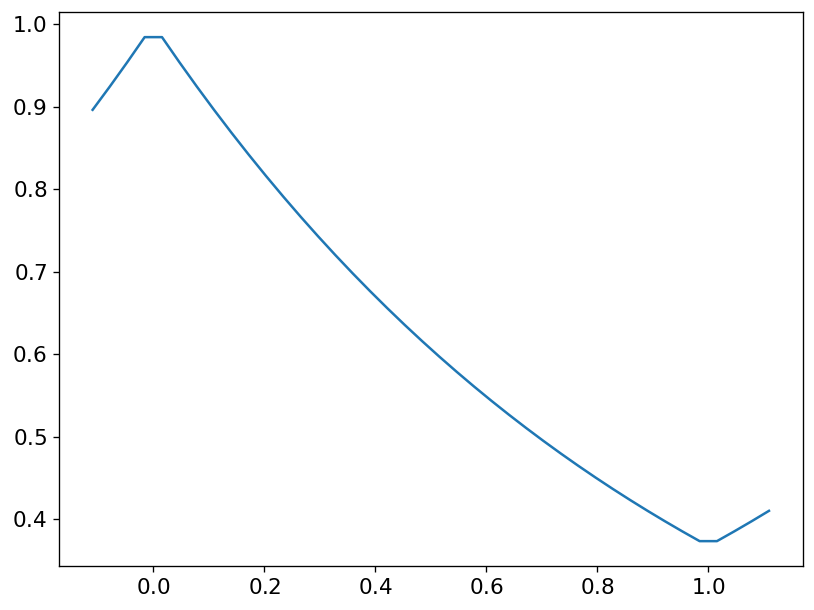

In [12]:
fig, ax = plt.subplots()
ax.plot(e.grid.x, e.U[:, 0])

In [19]:
e.estimate_dt()
e.advance_step()

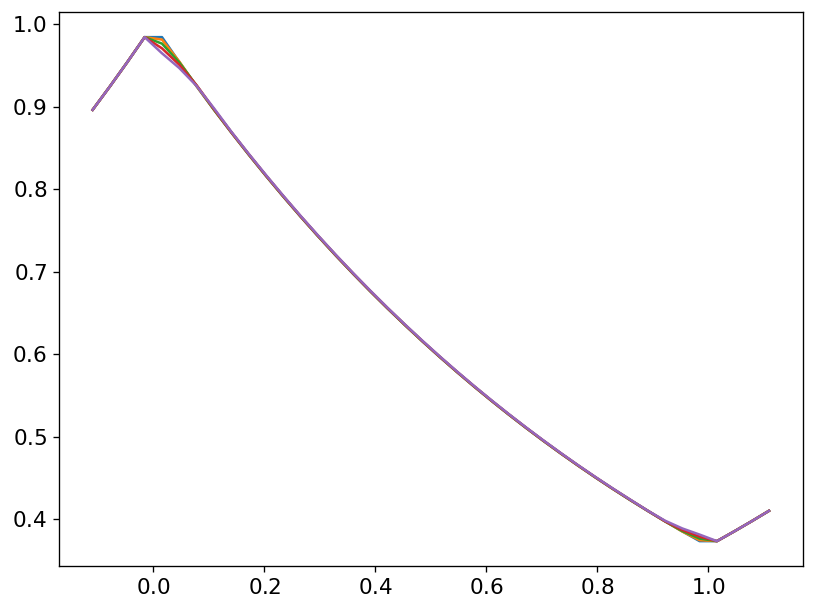

In [20]:
ax.plot(e.grid.x, e.U[:, 0])
fig